## Modelo LSTM simple (binario)

In [18]:
# ======================
# Importación de librerías
# ======================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
# ======================
# 1. Cargar y preparar datos
# ======================
df = pd.read_excel("../Datos/DB_Comentarios_Clean.xlsx")
df = df.dropna(subset=["comentarios_limpios_spacy", "calificacion"])

# Mapeo binario
rating_to_label = {1: "negativo", 2: "negativo", 3: "positivo", 4: "positivo", 5: "positivo"}
label_to_int = {"negativo": 0, "positivo": 1}
df["sentimiento"] = df["calificacion"].map(rating_to_label)
df["sentimiento_id"] = df["sentimiento"].map(label_to_int)

# División general train/test
X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    df["comentarios_limpios_spacy"], df["sentimiento_id"], test_size=0.2, stratify=df["sentimiento_id"], random_state=42
)


In [20]:
df.head()

,fecha,calificacion,comentario,comentarios_limpios_spacy,sentimiento,sentimiento_id
0,01 ene. 2024,1,"Producto con terminados horribles, manchado, p...",terminado horrible manchado pintura corrido di...,negativo,0
1,01 may. 2023,1,El producto es un poco ordinario y tuve que ma...,ordinario tener mandar él reparar rapido mes c...,negativo,0
2,02 oct. 2024,1,Talla incorrecta.,tallar incorrecto,negativo,0
3,02 sep. 2019,1,Definitivamente no cuadra en el pie.,definitivamente cuadrar pie,negativo,0
4,03 ene. 2025,1,"No son nada cómodos, la plantilla se corre y l...",comodo plantilla correr suela delgado,negativo,0


In [21]:
# ======================
# 2. Tokenización
# ======================
MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 100
NUM_EPOCHS = 25

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_texts)

X_train_seq = tokenizer.texts_to_sequences(X_train_texts)
X_test_seq = tokenizer.texts_to_sequences(X_test_texts)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")

In [22]:
# ======================
# 3. Definir el modelo LSTM
# ======================
model_lstm = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
# ======================
# 4. Entrenamiento con EarlyStopping
# ======================
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_lstm = model_lstm.fit(
    X_train_pad, y_train,
    epochs=NUM_EPOCHS,
    batch_size=32,
    validation_data=(X_test_pad, y_test),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/25
112/112 [==============================] - 3s 18ms/step - loss: 0.2403 - accuracy: 0.9558 - val_loss: 0.1767 - val_accuracy: 0.9575
Epoch 2/25
112/112 [==============================] - 2s 16ms/step - loss: 0.2008 - accuracy: 0.9572 - val_loss: 0.1780 - val_accuracy: 0.9575
Epoch 3/25
112/112 [==============================] - 2s 15ms/step - loss: 0.2029 - accuracy: 0.9572 - val_loss: 0.1807 - val_accuracy: 0.9575
Epoch 4/25
112/112 [==============================] - 2s 15ms/step - loss: 0.1930 - accuracy: 0.9572 - val_loss: 0.1760 - val_accuracy: 0.9575
Epoch 5/25
112/112 [==============================] - 2s 15ms/step - loss: 0.2179 - accuracy: 0.9407 - val_loss: 0.1809 - val_accuracy: 0.9575
Epoch 6/25
112/112 [==============================] - 2s 15ms/step - loss: 0.2095 - accuracy: 0.9572 - val_loss: 0.1770 - val_accuracy: 0.9575
Epoch 7/25
112/112 [==============================] - 2s 15ms/step - loss: 0.2072 - accuracy: 0.9572 - val_loss: 0.1757 - val_accuracy: 0.9575

28/28 [==============================] - 0s 5ms/step - loss: 0.1718 - accuracy: 0.9575

LSTM ➡ Loss: 0.1718 - Accuracy: 0.9575
28/28 [==============================] - 0s 4ms/step

Reporte de clasificación (LSTM):
              precision    recall  f1-score   support

    Negativo       0.00      0.00      0.00        38
    Positivo       0.96      1.00      0.98       857

    accuracy                           0.96       895
   macro avg       0.48      0.50      0.49       895
weighted avg       0.92      0.96      0.94       895



c:\Users\aluca\miniconda3\envs\tf_im_test\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\aluca\miniconda3\envs\tf_im_test\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\aluca\miniconda3\envs\tf_im_test\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


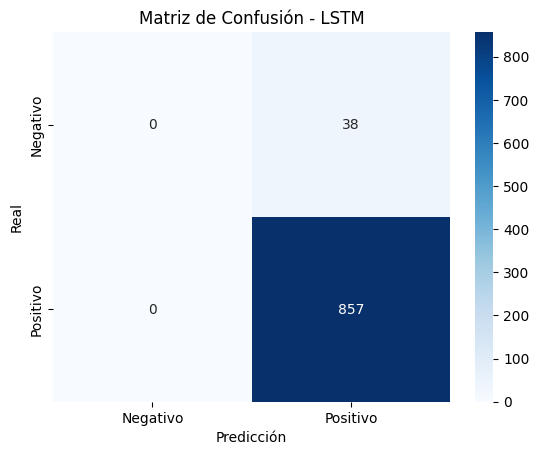

In [24]:
# ======================
# 5. Evaluación final y métricas
# ======================
loss, accuracy = model_lstm.evaluate(X_test_pad, y_test)
print(f"\nLSTM ➡ Loss: {loss:.4f} - Accuracy: {accuracy:.4f}")

y_pred_prob = model_lstm.predict(X_test_pad).flatten()
y_pred_bin = (y_pred_prob > 0.5).astype(int)

print("\nReporte de clasificación (LSTM):")
print(classification_report(y_test, y_pred_bin, target_names=["Negativo", "Positivo"], digits=2))

conf_matrix = confusion_matrix(y_test, y_pred_bin)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Negativo", "Positivo"], yticklabels=["Negativo", "Positivo"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - LSTM")
plt.show()

## Modelo Bidirectional LSTM (BiLSTM)

In [25]:
from tensorflow.keras.layers import Bidirectional

Epoch 1/25
112/112 [==============================] - 5s 29ms/step - loss: 0.2417 - accuracy: 0.9530 - val_loss: 0.1679 - val_accuracy: 0.9575
Epoch 2/25
112/112 [==============================] - 3s 24ms/step - loss: 0.1622 - accuracy: 0.9572 - val_loss: 0.1366 - val_accuracy: 0.9575
Epoch 3/25
112/112 [==============================] - 3s 24ms/step - loss: 0.0935 - accuracy: 0.9673 - val_loss: 0.1534 - val_accuracy: 0.9575
Epoch 4/25
112/112 [==============================] - 3s 24ms/step - loss: 0.0584 - accuracy: 0.9816 - val_loss: 0.1840 - val_accuracy: 0.9564
Epoch 5/25
112/112 [==============================] - 3s 24ms/step - loss: 0.0385 - accuracy: 0.9897 - val_loss: 0.2023 - val_accuracy: 0.9553
Epoch 6/25
112/112 [==============================] - 3s 24ms/step - loss: 0.0362 - accuracy: 0.9891 - val_loss: 0.2088 - val_accuracy: 0.9542
Epoch 7/25
28/28 [==============================] - 0s 6ms/step - loss: 0.1366 - accuracy: 0.9575

BiLSTM ➡ Loss: 0.1366 - Accuracy: 0.9575
28

c:\Users\aluca\miniconda3\envs\tf_im_test\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\aluca\miniconda3\envs\tf_im_test\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\aluca\miniconda3\envs\tf_im_test\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


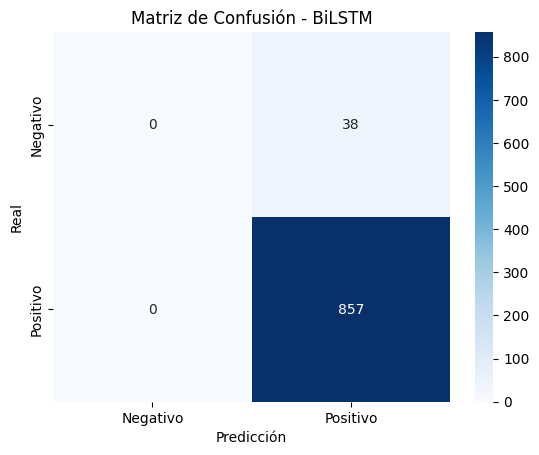

In [26]:
# ======================
# Definir el modelo BiLSTM
# ======================
model_bilstm = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_bilstm.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# ======================
# Entrenamiento
# ======================
history_bilstm = model_bilstm.fit(
    X_train_pad, y_train,
    epochs=NUM_EPOCHS,
    batch_size=32,
    validation_data=(X_test_pad, y_test),
    callbacks=[early_stop],
    verbose=1
)

# ======================
# Evaluación final y métricas
# ======================
loss, accuracy = model_bilstm.evaluate(X_test_pad, y_test)
print(f"\nBiLSTM ➡ Loss: {loss:.4f} - Accuracy: {accuracy:.4f}")

y_pred_prob_bi = model_bilstm.predict(X_test_pad).flatten()
y_pred_bin_bi = (y_pred_prob_bi > 0.5).astype(int)

print("\n📋 Reporte de clasificación (BiLSTM):")
print(classification_report(y_test, y_pred_bin_bi, target_names=["Negativo", "Positivo"], digits=2))

conf_matrix = confusion_matrix(y_test, y_pred_bin_bi)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Negativo", "Positivo"], yticklabels=["Negativo", "Positivo"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - BiLSTM")
plt.show()

In [46]:
# =========================
# Importación de librerías
# =========================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import matplotlib.pyplot as plt

In [51]:
# =========================
# 1. Cargar y preparar datos
# =========================
df = pd.read_excel("../Datos/DB_Comentarios_Clean.xlsx")
df = df.dropna(subset=["comentarios_limpios_spacy", "calificacion"])

rating_to_label = {1: "negativo", 2: "negativo", 3: "negativo", 4: "positivo", 5: "positivo"}
label_to_int = {"negativo": 0, "positivo": 1}
df["sentimiento"] = df["calificacion"].map(rating_to_label)
df["sentimiento_id"] = df["sentimiento"].map(label_to_int)

# =========================
# 2. Tokenización
# =========================
MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 100
NUM_EPOCHS = 15

# Crear tokenizer general
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df["comentarios_limpios_spacy"])

In [52]:
# =========================
# 3. Definir función de modelo BiLSTM
# =========================
def build_bilstm_model():
    model = Sequential([
        Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
        Bidirectional(LSTM(64, return_sequences=False)),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [55]:
# =========================
# 4. Ensemble con undersampling
# =========================
df_neg = df[df["sentimiento_id"] == 0]
df_pos = df[df["sentimiento_id"] == 1]

N = 30
modelos = []

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

for i in range(N):
    df_pos_sample = resample(df_pos, replace=False, n_samples=len(df_neg), random_state=42 + i)
    df_bal = pd.concat([df_pos_sample, df_neg]).sample(frac=1, random_state=42 + i)

    X_bal_seq = tokenizer.texts_to_sequences(df_bal["comentario"])
    X_bal_pad = pad_sequences(X_bal_seq, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")
    y_bal = df_bal["sentimiento_id"].values

    model_i = build_bilstm_model()
    model_i.fit(X_bal_pad, y_bal, epochs=NUM_EPOCHS, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=1)
    modelos.append(model_i)

print(f"\n✅ Entrenamiento finalizado: {N} modelos BiLSTM entrenados")

Epoch 1/15
20/20 [==============================] - 5s 185ms/step - loss: 0.6843 - accuracy: 0.5813 - val_loss: 0.6712 - val_accuracy: 0.6000
Epoch 2/15
20/20 [==============================] - 3s 158ms/step - loss: 0.6403 - accuracy: 0.6844 - val_loss: 0.6442 - val_accuracy: 0.6687
Epoch 3/15
20/20 [==============================] - 3s 157ms/step - loss: 0.6096 - accuracy: 0.6812 - val_loss: 0.6215 - val_accuracy: 0.6750
Epoch 4/15
20/20 [==============================] - 3s 157ms/step - loss: 0.5890 - accuracy: 0.7109 - val_loss: 0.6067 - val_accuracy: 0.6500
Epoch 5/15
20/20 [==============================] - 3s 154ms/step - loss: 0.5465 - accuracy: 0.7563 - val_loss: 0.5630 - val_accuracy: 0.7188
Epoch 6/15
20/20 [==============================] - 3s 153ms/step - loss: 0.5043 - accuracy: 0.7750 - val_loss: 0.5165 - val_accuracy: 0.7625
Epoch 7/15
20/20 [==============================] - 3s 153ms/step - loss: 0.4249 - accuracy: 0.8203 - val_loss: 0.5383 - val_accuracy: 0.7937
Epoch 


📊 Accuracy (Ensemble BiLSTM): 0.7855

📋 Reporte de clasificación (Ensemble BiLSTM):
              precision    recall  f1-score   support

    Negativo       0.28      0.89      0.43        80
    Positivo       0.99      0.78      0.87       815

    accuracy                           0.79       895
   macro avg       0.63      0.83      0.65       895
weighted avg       0.92      0.79      0.83       895



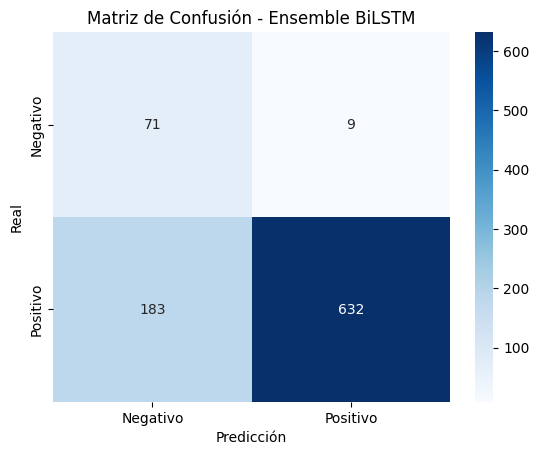

In [56]:
# =========================
# 5. Predicción y evaluación del ensemble
# =========================
# Preparar conjunto de prueba global
X_all_seq = tokenizer.texts_to_sequences(df["comentario"])
X_all_pad = pad_sequences(X_all_seq, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")
y_all = df["sentimiento_id"].values

X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_all_pad, y_all, test_size=0.2, stratify=y_all, random_state=42
)

# Predicciones del ensemble
preds = np.array([model.predict(X_test_final, verbose=0).flatten() for model in modelos])
promedio_preds = np.mean(preds, axis=0)
y_pred_binario = (promedio_preds > 0.5).astype(int)

# Evaluación
print(f"\n📊 Accuracy (Ensemble BiLSTM): {accuracy_score(y_test_final, y_pred_binario):.4f}")
print("\n📋 Reporte de clasificación (Ensemble BiLSTM):")
print(classification_report(y_test_final, y_pred_binario, target_names=["Negativo", "Positivo"], digits=2))

conf_matrix = confusion_matrix(y_test_final, y_pred_binario)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Negativo", "Positivo"], yticklabels=["Negativo", "Positivo"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Ensemble BiLSTM")
plt.show()

